In [55]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K
import os
import cv2
from sklearn.metrics import accuracy_score
from tensorflow.keras import layers
from tensorflow.keras import metrics
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Model
from ultralytics import YOLO
import glob
import pandas as pd
import shutil

In [210]:
def preprocess(array):
    """
    Normalizes the supplied array and reshapes it into the appropriate format.
    """

    array = array.astype('float32') / 255.
    array = np.reshape(array, (len(array), 28, 28, 1))
    return array


def display_pairs(images, labels, correct=None):
    """
    Displays the first ten pairs from the supplied array.

    Args:
        - images: An array containing the pair of images.
        - labels: An array containing the corresponding label (0 if both 
            pairs are different, and 1 if both pairs are the same.)
        - correct (optional): An array of boolean values indicating whether 
            the supplied labels correctly represent the image pairs.
    """

    n = 10

    plt.figure(figsize=(20, 6))
    for i, (image1, image2) in enumerate(zip(images[:n, 0], images[:n, 1])):
        label = int(labels[:n][i][0])

        text = "Label"
        color = "silver"

        # If we know whether the supplied labels are correct, let's change the
        # text and the face color of the annotation on the chart.
        if correct is not None:
            text = "Prediction"
            color = "mediumseagreen" if correct[:n][i][0] else "indianred"
            
        ax = plt.subplot(3, n, i + 1)
        ax.text(1, -3 ,f"{text}: {label}", style="italic", bbox={
            "facecolor": color, 
            "pad": 4
        })

        plt.imshow(image1.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        ax = plt.subplot(3, n, i + 1 + n)
        plt.imshow(image2.reshape(28, 28))
        plt.gray()
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    plt.show()


def plot_history(history):
    """
    Plots the training and validation loss.
    """

    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('Training and Validation Loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper right')
    plt.show()


def generate_pairs(images, labels):
    """
    Creates a collection of positive and negative image pairs from the supplied
    array of images.

    A positive pair contains two images of the same digit. A negative pair contains
    two images representing different digits.
    """

    preferred_digits = {'0', '2','7', '5', '6', '8', '9'}
    bias_strength = 0.7  # 70% of positive pairs come from preferred digits

    x_pairs = []
    y_pairs = []

    labels = np.array([str(l) for l in labels])  # ensure string comparison

    for i in range(len(images)):
        label = labels[i]

        # Biased positive pair: prefer preferred digits with probability
        if label in preferred_digits or np.random.rand() < bias_strength:
            pos_indices = np.where(labels == label)[0]
            pos_indices = pos_indices[pos_indices != i]  # avoid same image
            if len(pos_indices) > 0:
                j = np.random.choice(pos_indices)
                x_pairs.append([images[i], images[j]])
                y_pairs.append([1])
        else:
            # fallback: pick any valid positive
            j = np.random.choice(np.where(labels == label)[0])
            x_pairs.append([images[i], images[j]])
            y_pairs.append([1])

        # Negative pair (unchanged)
        k = np.random.choice(np.where(labels != label)[0])
        x_pairs.append([images[i], images[k]])
        y_pairs.append([0])

    indices = np.arange(len(x_pairs))
    np.random.shuffle(indices)

    return np.array(x_pairs)[indices], np.array(y_pairs)[indices]

In [82]:
detect_model = YOLO("digit_detection.pt")
class_map_digits = {
    0: 'number',
    1: 'slash'
}

In [137]:
REGION_ROOT = "trainning_siamese"
import os
import glob
import shutil
import pandas as pd

def save_labeled_digits(field="dob"):
    digit_dir = os.path.join(REGION_ROOT, f"digits_{field}")
    labeled_dir = os.path.join(REGION_ROOT, f"labeled_digits_{field}")
    os.makedirs(labeled_dir, exist_ok=True)

    # Load labels
    csv_path = "trainning_siamese/crop_labels.csv"
    df = pd.read_csv(csv_path)
    label_dict = dict(zip(df['crop_filename'], df['label']))

    # Get first 500 cropped digit files
    cropped_files = sorted(glob.glob(os.path.join(digit_dir, "*.jpg")))
    print(f"Processing {len(cropped_files)} files from {digit_dir}")

    for file in cropped_files:
        fname = os.path.basename(file)  # e.g., dob_00001_03.jpg
        key = '_'.join(fname.split('_')[:2]) + '.jpg'  # → dob_00001.jpg
        index = int(fname.split('_')[-1].split('.')[0])  # → 03
        # Check if the key exists in the label dictionary

        if key not in label_dict:
            print(f"Warning: {key} not found in label dictionary. Skipping file {file}.")
            continue

        label_str = label_dict[key]
        label_str = label_dict[key].replace("/", "")
        if index >= len(label_str):
            continue

        char = label_str[index]
        if not char.isdigit():
            continue  # Skip slashes

        out_folder = os.path.join(labeled_dir, char)
        os.makedirs(out_folder, exist_ok=True)

        shutil.copy(file, os.path.join(out_folder, fname))



def cropped_digits(img_path, field):
    if field == "dob":
        output_dir = os.path.join(REGION_ROOT, "digits_dob")
    else:
        output_dir = os.path.join(REGION_ROOT, "digits_id")
    fname = os.path.basename(img_path)
    base, ext = os.path.splitext(fname)
    
    # 1) Run inference
    res = detect_model(img_path, conf=0.75, verbose=False, save=True, save_txt=True)[0]
    boxes   = res.boxes.xyxy.cpu().numpy()
    classes = res.boxes.cls.cpu().numpy().astype(int)
    img = cv2.imread(img_path)
 
    bboxes = []
    for cls_id, (x1, y1, x2, y2) in zip(classes, boxes):
        if cls_id == 0:
            x1, y1, x2, y2 = map(int, [x1, y1, x2, y2])
            if x2 - x1 > 2 and y2 - y1 > 2:  # filter tiny boxes
                bboxes.append((x1, y1, x2, y2))

    if not bboxes:
        print(f"[{fname}] No class-0 digits found.")
        return
    if len(bboxes) != 8:
        print(f"⚠️ {fname}: {len(bboxes)} digits found (expected 8)")
        return

    # 4) Sort left to right
    bboxes.sort(key=lambda box: box[0])

    # 5) Crop and save
    os.makedirs(output_dir, exist_ok=True)

    for i, (x1, y1, x2, y2) in enumerate(bboxes):
        crop = img[y1:y2, x1:x2]
        crop = cv2.resize(crop, (28, 28))
        crop = cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY)
        out_name = f"{base}_{i:02d}.jpg"
        out_path = os.path.join(output_dir, out_name)
        cv2.imwrite(out_path, crop)

img_paths = sorted(glob.glob("trainning_siamese/crops_dob/*.jpg"))
for img_path in img_paths:
    cropped_digits(img_path, "dob")

save_labeled_digits("dob")



Results saved to runs/detect/predict11
1000 labels saved to runs/detect/predict11/labels
⚠️ dob_00000.jpg: 7 digits found (expected 8)
Results saved to runs/detect/predict11
1000 labels saved to runs/detect/predict11/labels
Results saved to runs/detect/predict11
1000 labels saved to runs/detect/predict11/labels
Results saved to runs/detect/predict11
1000 labels saved to runs/detect/predict11/labels
Results saved to runs/detect/predict11
1000 labels saved to runs/detect/predict11/labels
Results saved to runs/detect/predict11
1000 labels saved to runs/detect/predict11/labels
⚠️ dob_00005.jpg: 7 digits found (expected 8)
Results saved to runs/detect/predict11
1000 labels saved to runs/detect/predict11/labels
Results saved to runs/detect/predict11
1000 labels saved to runs/detect/predict11/labels
⚠️ dob_00007.jpg: 7 digits found (expected 8)
Results saved to runs/detect/predict11
1000 labels saved to runs/detect/predict11/labels
⚠️ dob_00008.jpg: 9 digits found (expected 8)
Results saved t

In [533]:
REGION_ROOT = "cropped_dob_valid_1"
def cropped_digits(img_path, field):
    if field == "dob":
        output_dir = os.path.join(REGION_ROOT, "digits_dob")
    else:
        output_dir = os.path.join(REGION_ROOT, "digits_id")
    fname = os.path.basename(img_path)
    base, ext = os.path.splitext(fname)
    
    # 1) Run inference
    res = detect_model(img_path, conf=0.82, verbose=False, save=True, save_txt=True)[0]
    boxes   = res.boxes.xyxy.cpu().numpy()
    classes = res.boxes.cls.cpu().numpy().astype(int)
    img = cv2.imread(img_path)
 
    bboxes = []
    for cls_id, (x1, y1, x2, y2) in zip(classes, boxes):
        if cls_id == 0:
            x1, y1, x2, y2 = map(int, [x1, y1, x2, y2])
            if x2 - x1 > 2 and y2 - y1 > 2:  # filter tiny boxes
                bboxes.append((x1, y1, x2, y2))

    if not bboxes:
        print(f"[{fname}] No class-0 digits found.")
        return
    if len(bboxes) != 8:
        print(f"⚠️ {fname}: {len(bboxes)} digits found (expected 8)")
        return

    # 4) Sort left to right
    bboxes.sort(key=lambda box: box[0])

    # 5) Crop and save
    os.makedirs(output_dir, exist_ok=True)
    for i, (x1, y1, x2, y2) in enumerate(bboxes):
        crop = img[y1:y2, x1:x2]
        crop = cv2.resize(crop, (28, 28))
        crop = cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY)
        out_name = f"{base}_{i:02d}.jpg"
        out_path = os.path.join(output_dir, out_name)
        cv2.imwrite(out_path, crop)

img_paths = sorted(glob.glob("cropped_dob_valid_1/*.jpg"))
for img_path in img_paths:
    cropped_digits(img_path, "dob")



Results saved to runs/detect/predict10
1245 labels saved to runs/detect/predict10/labels
Results saved to runs/detect/predict10
1245 labels saved to runs/detect/predict10/labels
Results saved to runs/detect/predict10
1245 labels saved to runs/detect/predict10/labels
Results saved to runs/detect/predict10
1245 labels saved to runs/detect/predict10/labels
Results saved to runs/detect/predict10
1245 labels saved to runs/detect/predict10/labels
Results saved to runs/detect/predict10
1245 labels saved to runs/detect/predict10/labels
Results saved to runs/detect/predict10
1245 labels saved to runs/detect/predict10/labels
Results saved to runs/detect/predict10
1245 labels saved to runs/detect/predict10/labels
Results saved to runs/detect/predict10
1245 labels saved to runs/detect/predict10/labels
Results saved to runs/detect/predict10
1245 labels saved to runs/detect/predict10/labels
Results saved to runs/detect/predict10
1245 labels saved to runs/detect/predict10/labels
Results saved to runs

In [496]:
def save_labeled_digits(field="dob"):
    digit_dir = os.path.join(REGION_ROOT, f"digits_{field}")
    labeled_dir = os.path.join(REGION_ROOT, f"labeled_digits_{field}")
    os.makedirs(labeled_dir, exist_ok=True)

    # Load labels
    csv_path = "gt_2s.csv"
    df = pd.read_csv(csv_path)
    label_dict = dict(zip(df['filename'], df['dob']))

    # Get first 500 cropped digit files
    cropped_files = sorted(glob.glob(os.path.join(digit_dir, "*.jpg")))
    
    for file in cropped_files:

        fname = os.path.basename(file)  # e.g., dob_00001_03.jpg
        key = '_'.join(fname.split('_')[:1])+'.jpg'   # → dob_00001.jpg
        index = int(fname.split('_')[-1].split('.')[0])  # → 03

        # Check if the key exists in the label dictionary

        if key not in label_dict:
            print(f"Warning: {key} not found in label dictionary. Skipping file {file}.")
            continue

        label_str = label_dict[key]
        label_str = label_dict[key].replace("/", "")
        if index >= len(label_str):
            continue

        char = label_str[index]
        if not char.isdigit():
            continue  # Skip slashes

        out_folder = os.path.join(labeled_dir, char)
        os.makedirs(out_folder, exist_ok=True)

        shutil.copy(file, os.path.join(out_folder, fname))

save_labeled_digits("dob")



In [124]:
REGION_ROOT = "template"
import os
import glob
import shutil
import pandas as pd

def save_labeled_digits(field="dob"):
    digit_dir = os.path.join(REGION_ROOT, f"digits_{field}")
    labeled_dir = os.path.join(REGION_ROOT, f"labeled_digits_{field}")
    os.makedirs(labeled_dir, exist_ok=True)

    # Load labels
    csv_path = "template/crop_labels.csv"
    df = pd.read_csv(csv_path)
    label_dict = dict(zip(df['crop_filename'], df['label']))

    # Get first 500 cropped digit files
    cropped_files = sorted(glob.glob(os.path.join(digit_dir, "*.jpg")))
    print(f"Processing {len(cropped_files)} files from {digit_dir}")

    for file in cropped_files:       

        fname = os.path.basename(file)  # e.g., dob_00001_03.jpg
        key = '_'.join(fname.split('_')[:2]) + '.jpg'  # → dob_00001.jpg
        index = int(fname.split('_')[-1].split('.')[0])  # → 03
        # Check if the key exists in the label dictionary

        if key not in label_dict:
            print(f"Warning: {key} not found in label dictionary. Skipping file {file}.")
            continue

        label_str = label_dict[key]
        label_str = label_dict[key].replace("/", "")
        if index >= len(label_str):
            continue

        char = label_str[index]
        if not char.isdigit():
            continue  # Skip slashes

        out_folder = os.path.join(labeled_dir, char)
        os.makedirs(out_folder, exist_ok=True)

        shutil.copy(file, os.path.join(out_folder, fname))



def cropped_digits(img_path, field):
    if field == "dob":
        output_dir = os.path.join(REGION_ROOT, "digits_dob")
    else:
        output_dir = os.path.join(REGION_ROOT, "digits_id")
    fname = os.path.basename(img_path)
    base, ext = os.path.splitext(fname)
    
    # 1) Run inference
    res = detect_model(img_path, conf=0.7, verbose=False, save=True, save_txt=True)[0]
    boxes   = res.boxes.xyxy.cpu().numpy()
    classes = res.boxes.cls.cpu().numpy().astype(int)
    img = cv2.imread(img_path)
 
    bboxes = []
    for cls_id, (x1, y1, x2, y2) in zip(classes, boxes):
        if cls_id == 0:
            x1, y1, x2, y2 = map(int, [x1, y1, x2, y2])
            if x2 - x1 > 2 and y2 - y1 > 2:  # filter tiny boxes
                bboxes.append((x1, y1, x2, y2))

    if not bboxes:
        print(f"[{fname}] No class-0 digits found.")
        return
    if len(bboxes) != 8:
        print(f"⚠️ {fname}: {len(bboxes)} digits found (expected 8)")

    # 4) Sort left to right
    bboxes.sort(key=lambda box: box[0])

    # 5) Crop and save
    os.makedirs(output_dir, exist_ok=True)
    for i, (x1, y1, x2, y2) in enumerate(bboxes):
        crop = img[y1:y2, x1:x2]
        crop = cv2.resize(crop, (28, 28))
        crop = cv2.cvtColor(crop, cv2.COLOR_BGR2GRAY)
        out_name = f"{base}_{i:02d}.jpg"
        out_path = os.path.join(output_dir, out_name)
        cv2.imwrite(out_path, crop)
img_paths = sorted(glob.glob("template/crops_dob/*.jpg"))
for img_path in img_paths:
    cropped_digits(img_path, "dob")

save_labeled_digits("dob")



Results saved to runs/detect/predict11
1000 labels saved to runs/detect/predict11/labels
Results saved to runs/detect/predict11
1000 labels saved to runs/detect/predict11/labels
Results saved to runs/detect/predict11
1000 labels saved to runs/detect/predict11/labels
Results saved to runs/detect/predict11
1000 labels saved to runs/detect/predict11/labels
Results saved to runs/detect/predict11
1000 labels saved to runs/detect/predict11/labels
Results saved to runs/detect/predict11
1000 labels saved to runs/detect/predict11/labels
⚠️ dob_00005.jpg: 7 digits found (expected 8)
Results saved to runs/detect/predict11
1000 labels saved to runs/detect/predict11/labels
⚠️ dob_00006.jpg: 6 digits found (expected 8)
Results saved to runs/detect/predict11
1000 labels saved to runs/detect/predict11/labels
Results saved to runs/detect/predict11
1000 labels saved to runs/detect/predict11/labels
Results saved to runs/detect/predict11
1000 labels saved to runs/detect/predict11/labels
Results saved to r

In [211]:
# Load full training data (we'll split validation from it)
full_train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "trainning_siamese/labeled_digits_dob",
    labels='inferred',
    label_mode='int',
    color_mode='grayscale',      # use 'rgb' if your model expects 3 channels
    image_size=(28, 28),
    shuffle=True,
    batch_size=None              # unbatched: returns (image, label) tuples
)

# Load test set
valid_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "cropped_dob_valid_1/labeled_digits_dob",
    labels='inferred',
    label_mode='int',
    color_mode='grayscale',
    image_size=(28, 28),
    shuffle=False,
    batch_size=None
)
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "cropped_dob_train/labeled_digits_dob",
    labels='inferred',
    label_mode='int',
    color_mode='grayscale',
    image_size=(28, 28),
    shuffle=False,
    batch_size=None
)
template_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "template/labeled_digits_dob",
    labels='inferred',
    label_mode='int',
    color_mode='grayscale',
    image_size=(28, 28),
    shuffle=False,
    batch_size=None
)
def dataset_to_numpy(ds):
    images, labels = [], []
    for img, label in ds:
        images.append(img.numpy())
        labels.append(label.numpy())
    return np.stack(images), np.array(labels)

x_train, y_train = dataset_to_numpy(full_train_ds)
x_test, y_test = dataset_to_numpy(test_ds)
x_val, y_val = dataset_to_numpy(valid_ds)
x_temp, y_temp = dataset_to_numpy(template_ds)

# VALIDATION_SIZE = int(len(x_train) * 0.2)

# x_val = x_train[:VALIDATION_SIZE]
# y_val = y_train[:VALIDATION_SIZE]

# x_train = x_train[VALIDATION_SIZE:]
# y_train = y_train[VALIDATION_SIZE:]

x_train = preprocess(x_train)
x_val = preprocess(x_val)
x_test = preprocess(x_test)
x_temp = preprocess(x_temp)

print(f"Train: {len(x_train)}")
print(f"Validation: {len(x_val)}")
print(f"Test: {len(x_test)}")
print(f"Template: {len(x_temp)}")

Found 7064 files belonging to 10 classes.
Found 480 files belonging to 10 classes.
Found 1480 files belonging to 10 classes.
Found 100 files belonging to 10 classes.
Train: 7064
Validation: 480
Test: 1480
Template: 100


In [212]:
x_pairs_train, y_pairs_train = generate_pairs(x_train, y_train)
x_pairs_val, y_pairs_val = generate_pairs(x_val, y_val)
x_pairs_test, y_pairs_test = generate_pairs(x_test, y_test)

In [213]:
x_pairs_temp, y_pairs_temp = generate_pairs(x_temp, y_temp)

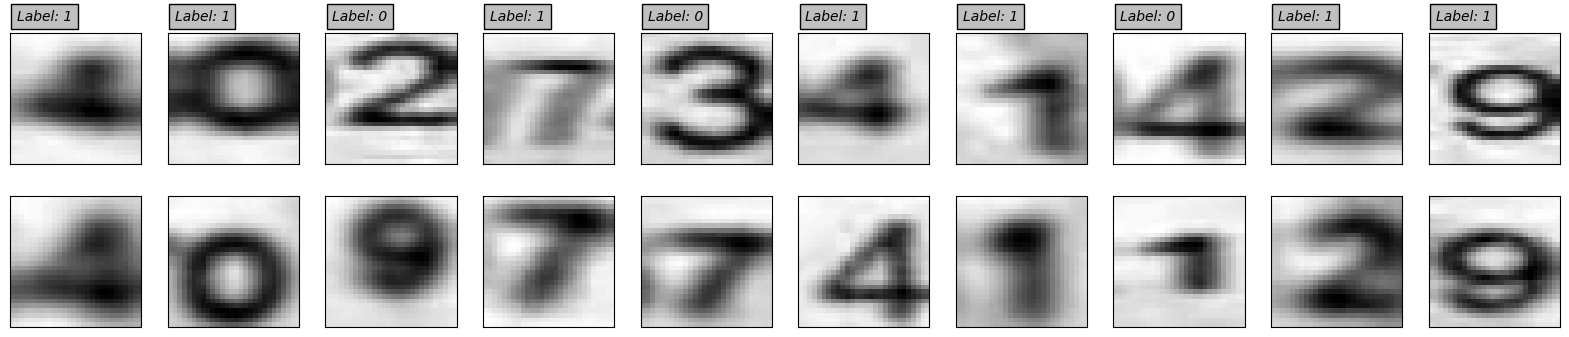

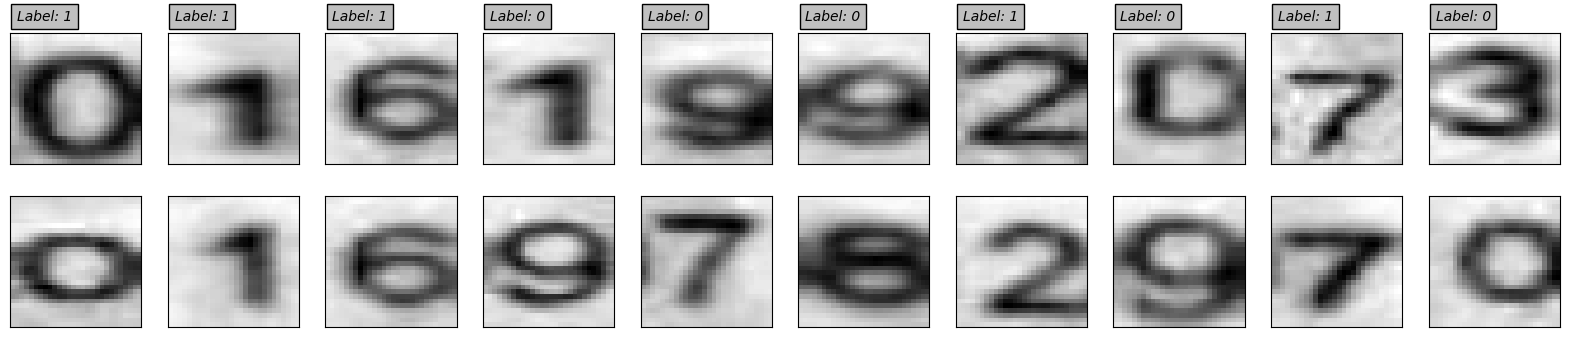

In [214]:
display_pairs(x_pairs_train, y_pairs_train)
display_pairs(x_pairs_val, y_pairs_val)


In [215]:
def norm(features):
    """
    Computes the euclidean norm of the two feature vectors generated
    by the twins of the Siamese network.
    """
    return tf.norm(features[0] - features[1], axis=1, keepdims=True)
 

def accuracy(y_true, y_pred):
    """
    Computes the accuracy of the predictions. 
    """

    # Notice that `y_true` is 0 whenever two images are not the same and 1 
    # otherwise, but `y_pred` is the opposite. The closer `y_pred` is to 0, 
    # the shorter the distance between both images, therefore the more likely 
    # it is that they are the same image. To correctly compute the accuracy we
    # need to substract `y_pred` from 1 so both vectors are comparable.
    return metrics.binary_accuracy(y_true, 1 - y_pred)


def contrastive_loss(y_true, y_pred):
    """
    Computes the contrastive loss introduced by Yann LeCun et al. in the paper
    "Dimensionality Reduction by Learning an Invariant Mapping," 2005.
    """

    margin = 1
    y_true = tf.cast(y_true, y_pred.dtype)

    # The original formula proposed by Yann LeCunn et al. assumes that Y is 0
    # if both images are similar and 1 otherwise. Our implementation (where Y is
    # `y_true`) is the opposite, hence the modification to the formula below.
    loss = y_true / 2 * K.square(y_pred) + (1 - y_true) / 2 \
                  * K.square(K.maximum(0.0, margin - y_pred))

    return loss

In [216]:
np.unique(y_pairs_train, return_counts=True)

(array([0, 1]), array([7064, 7064]))

In [217]:
def siamese_twin():
    """
    Creates the subnetwork that represents each one of the twins of the
    Siamese network.
    """

    inputs = layers.Input((28, 28, 1))

    x = layers.Conv2D(128, (3, 3), activation="relu")(inputs)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Conv2D(128, (3, 3), activation="relu")(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Conv2D(128, (3, 3), activation="relu")(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.2)(x)

    x = layers.GlobalAveragePooling2D()(x)

    # We don't want any activation function on the final layer. This layer
    # will contain the embedding for the input image.

    outputs = layers.Dense(128, activation=None)(x)

    return Model(inputs, outputs)
 
 
def siamese_network():
    """
    Creates the Siamese Network model.
    """

    input1 = layers.Input(shape=(28, 28, 1))
    input2 = layers.Input(shape=(28, 28, 1))

    twin = siamese_twin()

    # We can use a Lambda layer to compute the euclidean distance of the
    # embeddings from each image.
    distance = layers.Lambda(norm)([
        twin(input1), 
        twin(input2)
    ])

    # Our model has two inputs: the first input is for the anchor image and
    # the second input is for the second image of the pair. The output of the
    # model is the euclidean distance between the embeddings from each image.
    return Model(inputs=[input1, input2], outputs=distance)     

In [218]:
lr0 = 0.0005  # your initial learning rate

lr_schedule = tf.keras.optimizers.schedules.CosineDecay(
    initial_learning_rate=lr0,
    decay_steps=10000,
    alpha=0.1  # final_lr = alpha * initial_lr
)
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_cb = ModelCheckpoint(
    filepath='best_siamese_model.h5',
    monitor='val_accuracy',         # or 'val_accuracy' if using accuracy
    save_best_only=True,        # Only save the best version
    save_weights_only=False,    # Save entire model (architecture + weights)
    verbose=1
)
model = siamese_network()
model.compile(
    loss=contrastive_loss, 
    optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule), 
    metrics=[accuracy]
)

model.summary()

Model: "model_27"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_40 (InputLayer)       [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 input_41 (InputLayer)       [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 model_26 (Functional)       (None, 128)                  312960    ['input_40[0][0]',            
                                                                     'input_41[0][0]']            
                                                                                                  
 lambda_13 (Lambda)          (None, 1)                    0         ['model_26[0][0]',     

In [219]:
history = model.fit(
    x=[x_pairs_train[:, 0], x_pairs_train[:, 1]], 
    y=y_pairs_train[:], 
    validation_data=([x_pairs_val[:, 0], x_pairs_val[:, 1]], y_pairs_val[:]),
	batch_size=64,
	epochs=20,
    callbacks=[checkpoint_cb]
)

Epoch 1/20
221/221 [==============================] - ETA: 0s - loss: 0.1291 - accuracy: 0.5093
Epoch 1: val_accuracy improved from -inf to 0.50000, saving model to best_siamese_model.h5
221/221 [==============================] - 42s 187ms/step - loss: 0.1291 - accuracy: 0.5093 - val_loss: 0.2125 - val_accuracy: 0.5000
Epoch 2/20
  1/221 [..............................] - ETA: 27s - loss: 0.1175 - accuracy: 0.6719

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


221/221 [==============================] - ETA: 0s - loss: 0.1264 - accuracy: 0.5263
Epoch 2: val_accuracy improved from 0.50000 to 0.50104, saving model to best_siamese_model.h5
221/221 [==============================] - 34s 154ms/step - loss: 0.1264 - accuracy: 0.5263 - val_loss: 0.1672 - val_accuracy: 0.5010
Epoch 3/20
221/221 [==============================] - ETA: 0s - loss: 0.1042 - accuracy: 0.6627
Epoch 3: val_accuracy improved from 0.50104 to 0.72917, saving model to best_siamese_model.h5
221/221 [==============================] - 36s 164ms/step - loss: 0.1042 - accuracy: 0.6627 - val_loss: 0.0939 - val_accuracy: 0.7292
Epoch 4/20
221/221 [==============================] - ETA: 0s - loss: 0.0823 - accuracy: 0.7656
Epoch 4: val_accuracy improved from 0.72917 to 0.79479, saving model to best_siamese_model.h5
221/221 [==============================] - 33s 150ms/step - loss: 0.0823 - accuracy: 0.7656 - val_loss: 0.0694 - val_accuracy: 0.7948
Epoch 5/20
221/221 [===================

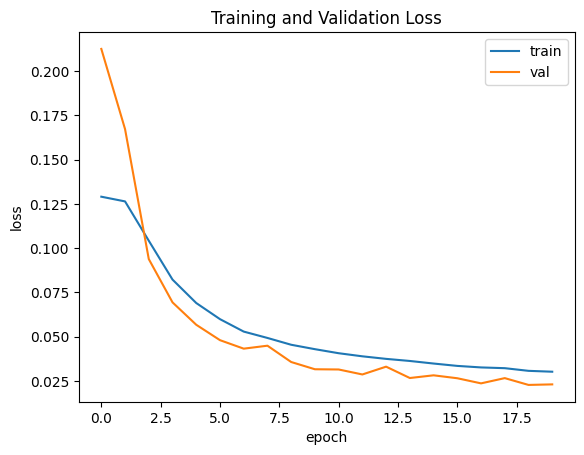

In [220]:
plot_history(history.history)

In [233]:
model.load_weights('best_siamese_cosine_model.keras')

30/30 [==============================] - 1s 24ms/step


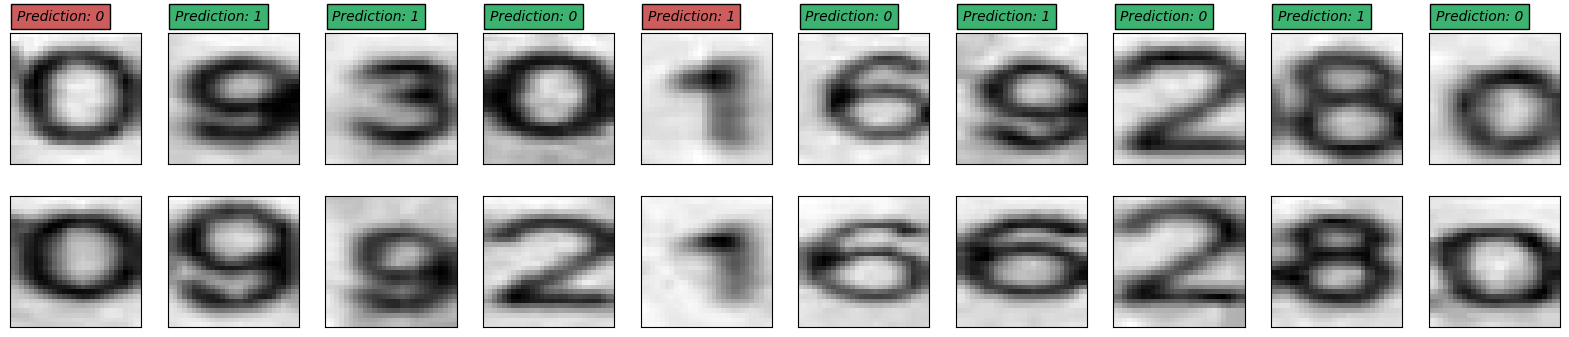


Accuracy: 0.8062499761581421


In [228]:
y_pred = model.predict([x_pairs_val[:, 0], x_pairs_val[:, 1]])

predictions = np.round(1 - y_pred)  # Convert distances to binary predictions
predictions[predictions < 0] = 0
display_pairs(x_pairs_test, predictions, predictions == y_pairs_val)

accuracy = metrics.BinaryAccuracy()
accuracy.update_state(y_pairs_val, predictions)
print(f"\nAccuracy: {accuracy.result().numpy()}")

93/93 [==============================] - 3s 27ms/step


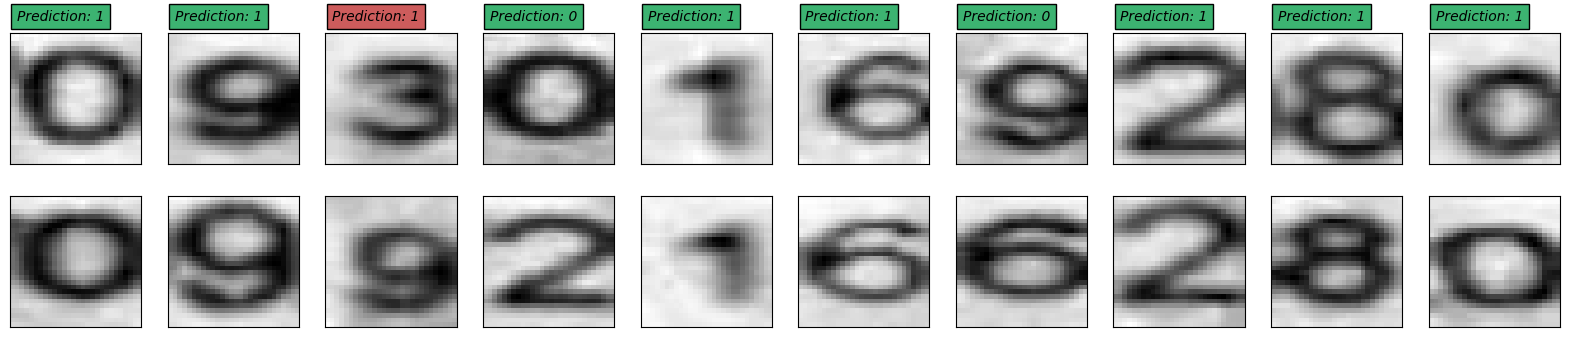


Accuracy: 0.862162172794342


In [229]:
y_pred = model.predict([x_pairs_test[:, 0], x_pairs_test[:, 1]])

predictions = np.round(1 - y_pred)  # Convert distances to binary predictions
predictions[predictions < 0] = 0
display_pairs(x_pairs_test, predictions, predictions == y_pairs_test)

accuracy = metrics.BinaryAccuracy()
accuracy.update_state(y_pairs_test, predictions)
print(f"\nAccuracy: {accuracy.result().numpy()}")

In [22]:
model.save("best_siamese_model.keras")

In [187]:
# Predict distances
y_pred = model.predict([x_pairs_test[:, 0], x_pairs_test[:, 1]])
same = y_pred[y_pairs_test == 1]
diff = y_pred[y_pairs_test == 0]

print("Same avg dist:", np.mean(same))
print("Diff avg dist:", np.mean(diff))

93/93 [==============================] - 2s 23ms/step
Same avg dist: 0.12691692
Diff avg dist: 1.0145032


In [188]:
def generate_test_template_pairs(test_images, template_dict):
    """
    Generates all (test, template) pairs between test images and all templates.

    Args:
        test_images (list of np.array): cropped DoB characters (28,28,1)
        template_dict (dict): {label: list of template images}

    Returns:
        x0: np.array of test images repeated
        x1: np.array of template images
        labels: list of template labels for each pair
        test_indices: index of the test image (to group results later)
    """
    x0 = []
    x1 = []
    labels = []
    test_indices = []

    for i, test_img in enumerate(test_images):
        for label, template_imgs in template_dict.items():
            for tmpl in template_imgs:
                x0.append(test_img)
                x1.append(tmpl)
                labels.append(label)
                test_indices.append(i)

    return np.array(x0), np.array(x1), labels, test_indices


In [189]:
from collections import defaultdict

def build_template_dict(x_temp, y_temp):
    """
    Builds a dictionary {digit: list of images} for Siamese matching.

    Args:
        x_temp (np.ndarray): shape (N, 28, 28, 1)
        y_temp (np.ndarray): shape (N,), with digits 0–9

    Returns:
        dict: {str(digit): list of images}
    """
    template_dict = defaultdict(list)

    for img, label in zip(x_temp, y_temp):
        digit = str(label)
        template_dict[digit].append(img)

    return dict(template_dict)


template_dict = build_template_dict(x_temp, y_temp)

In [190]:
import numpy as np
import matplotlib.pyplot as plt

def plot_top_k_matches(test_img, template_imgs, template_labels, distances, top_k=5):
    """
    Plots the test character and top-K closest templates.
    
    Parameters
    ----------
    test_img : array-like, shape=(H, W) or (H, W, 1)
        The query image.
    template_imgs : array-like, shape=(N, H, W) or (N, H, W, 1)
        All candidate templates.
    template_labels : sequence of length N
        Labels (e.g. digit class) for each template.
    distances : array-like, shape=(N,)
        Distance of test_img to each template.
    top_k : int, optional
        How many matches to display (default=5).
    """
    distances = distances.flatten()
    top_indices = np.argsort(distances)[:top_k]

    plt.figure(figsize=(2 * (top_k + 1), 3))

    # 1) Plot test image
    ax = plt.subplot(1, top_k + 1, 1)
    ax.imshow(test_img.squeeze(), cmap='gray')
    ax.set_title("Query")
    ax.axis('off')

    # 2) Plot top-K templates
    for rank, idx in enumerate(top_indices, start=2):
        ax = plt.subplot(1, top_k + 1, rank)
        ax.imshow(template_imgs[idx].squeeze(), cmap='gray')
        label = template_labels[idx]
        dist  = distances[idx]
        ax.set_title(f"{label}\n{dist:.2f}")
        ax.axis('off')

    plt.tight_layout()
    plt.show()


In [230]:
x_test_1 = x_test
y_test_1 = y_test

true_labels = []
predicted_labels = []
wrong_cases = []

val_image_paths = sorted(glob.glob("cropped_dob_train/labeled_digits_dob/*/*.jpg"))

for i, test_img in enumerate(x_test_1):
    filename = os.path.basename(val_image_paths[i])
    # Ground truth
    true_label = y_test_1[i]
    true_label_str = str(true_label)

    # Generate test-template pairs
    x0, x1, template_labels, test_indices = generate_test_template_pairs([test_img], template_dict)
    distances = model.predict([x0, x1])

    # Top-1 match
    distances = distances.flatten()
    best_idx = np.argmin(distances)
    predicted_label = template_labels[best_idx]

    # Append results
    true_labels.append(true_label_str)
    predicted_labels.append(predicted_label)
    if predicted_label != true_label_str:
        wrong_cases.append((test_img, x1, template_labels, distances, true_label_str, predicted_label, filename))

    if predicted_label != true_label_str:
        print(f"Filename: {filename}")
        print(f"True: {true_label_str} | Predicted: {predicted_label} | Distance: {distances[best_idx]:.4f}")


    # Visual check
    #plot_top_k_matches(test_img, x1, template_labels, distances, top_k=1)


5/5 [==============================] - 0s 17ms/step


KeyboardInterrupt: 

In [193]:
import numpy as np
accuracy = np.mean(np.array(true_labels) == np.array(predicted_labels))
print(f"\n✅ Accuracy on sampled test set: {accuracy * 100:.2f}%")



✅ Accuracy on sampled test set: 98.78%



 Wrong predictions: 18
Filename: img1338_00.jpg True: 2 | Predicted: 9


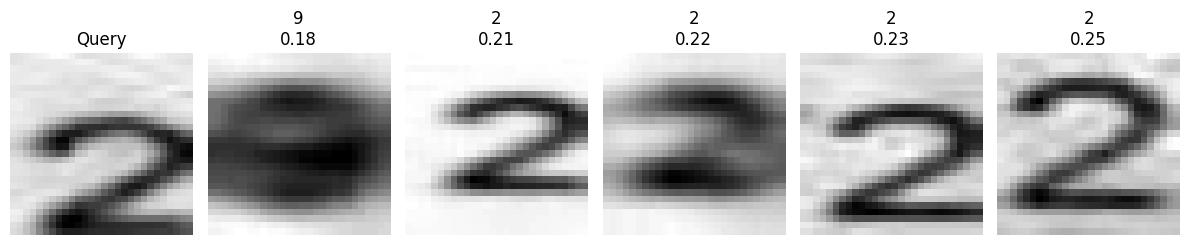

Filename: img1117_07.jpg True: 3 | Predicted: 5


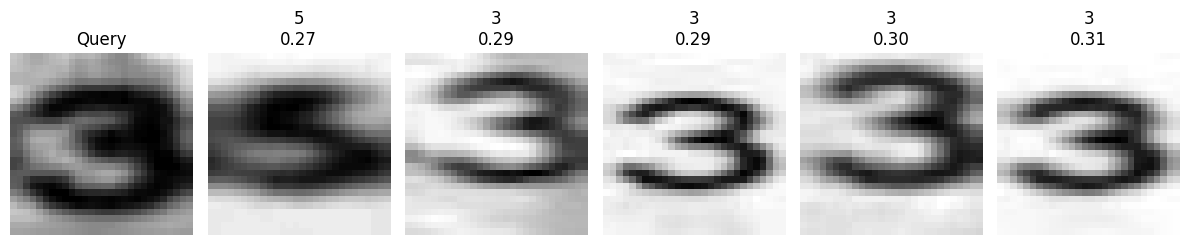

Filename: img1307_07.jpg True: 3 | Predicted: 5


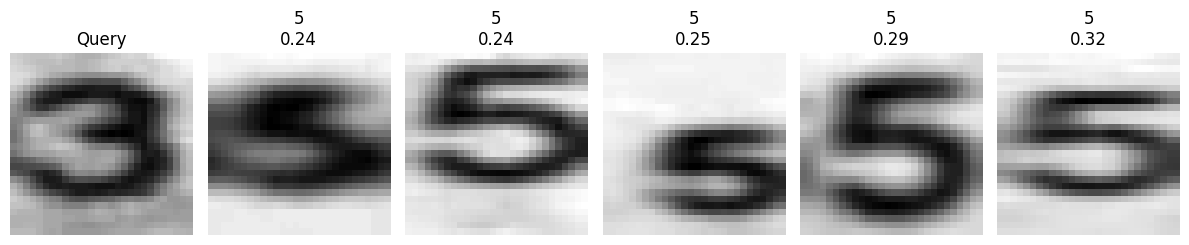

Filename: img1368_07.jpg True: 3 | Predicted: 5


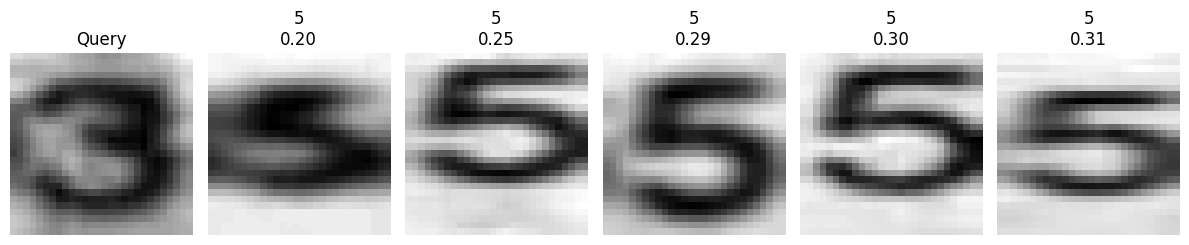

Filename: img1314_01.jpg True: 5 | Predicted: 8


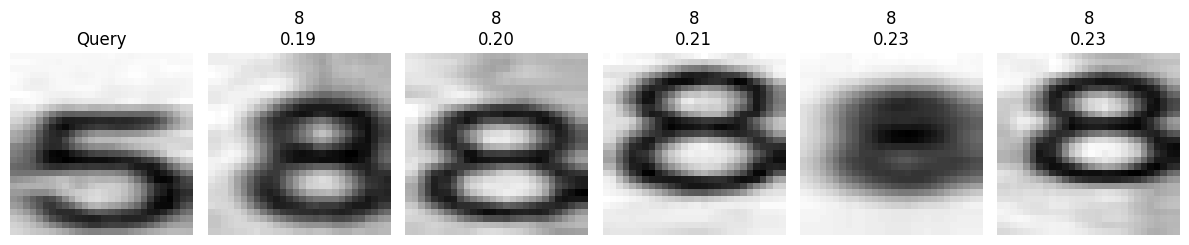

Filename: img1432_07.jpg True: 5 | Predicted: 8


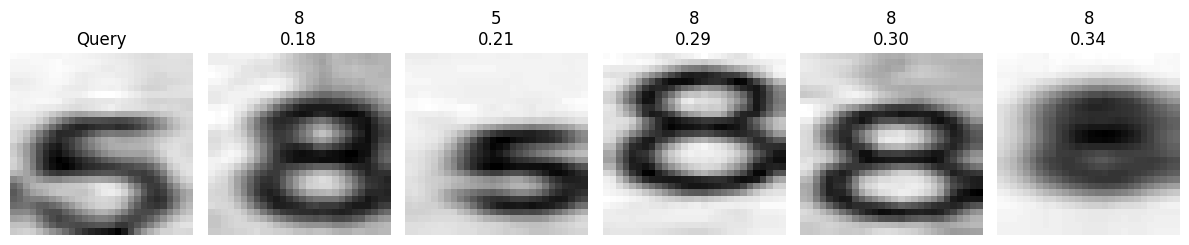

Filename: img1448_06.jpg True: 6 | Predicted: 8


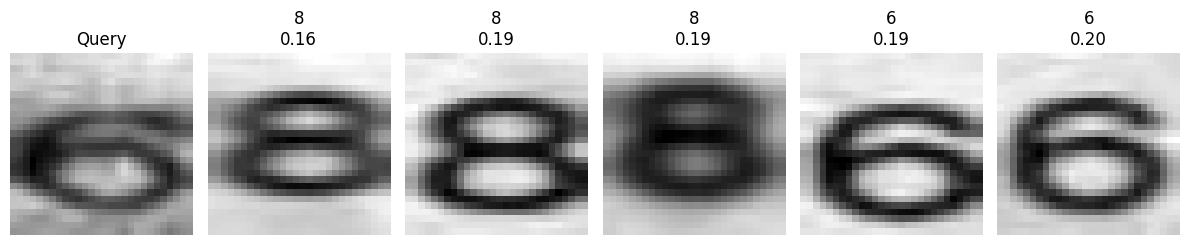

Filename: img1297_01.jpg True: 7 | Predicted: 2


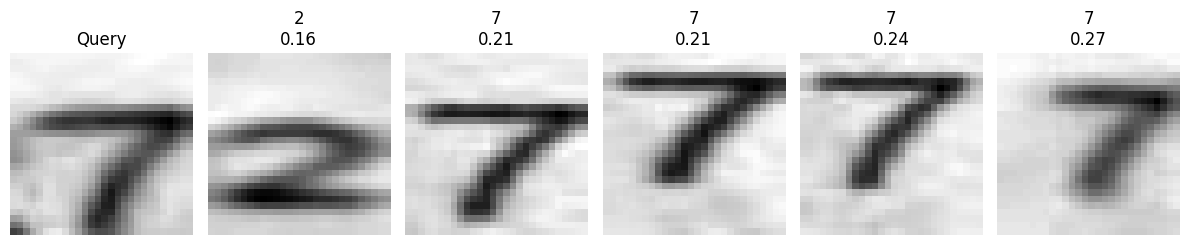

Filename: img1346_06.jpg True: 7 | Predicted: 2


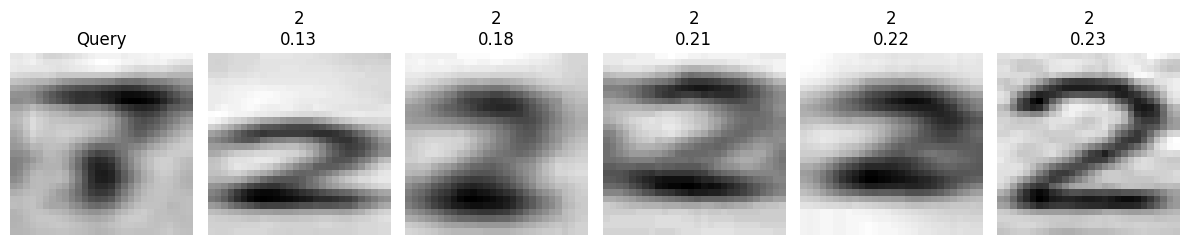

Filename: img1434_07.jpg True: 7 | Predicted: 2


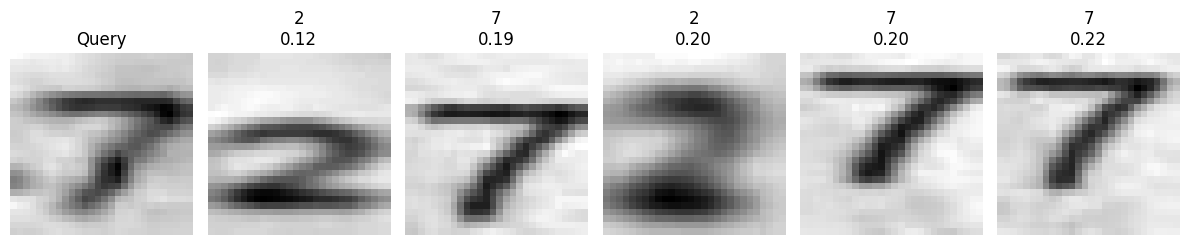

Filename: img1298_06.jpg True: 8 | Predicted: 6


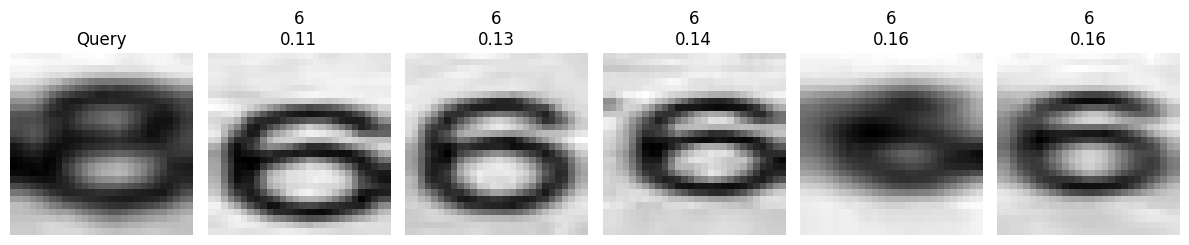

Filename: img1451_06.jpg True: 8 | Predicted: 6


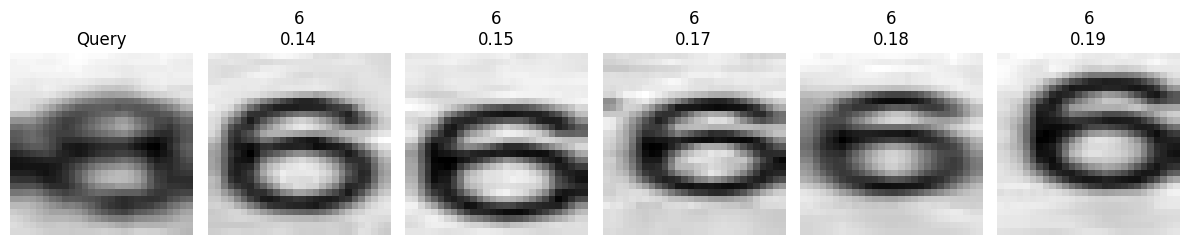

Filename: img1561_06.jpg True: 8 | Predicted: 6


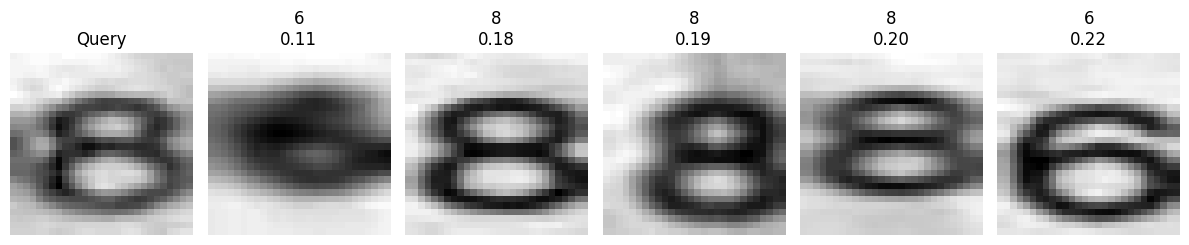

Filename: img1319_05.jpg True: 9 | Predicted: 0


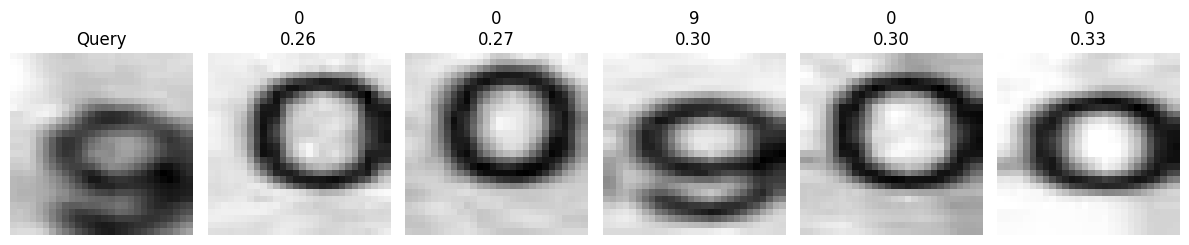

Filename: img1319_07.jpg True: 9 | Predicted: 0


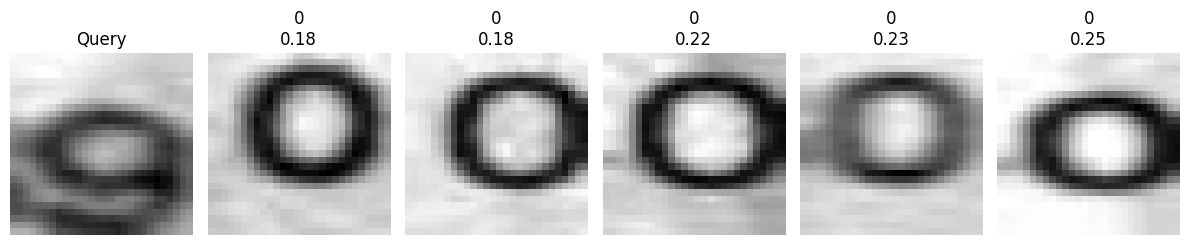

Filename: img1430_07.jpg True: 9 | Predicted: 0


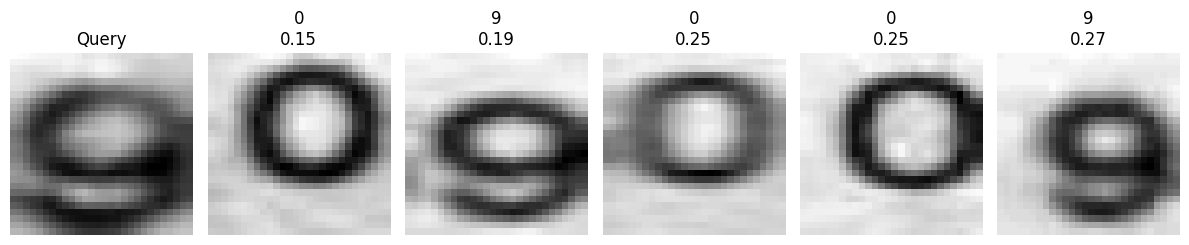

Filename: img1437_05.jpg True: 9 | Predicted: 0


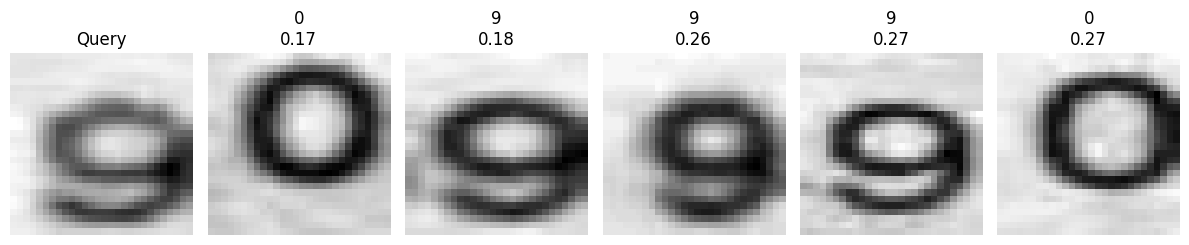

Filename: img1617_01.jpg True: 9 | Predicted: 0


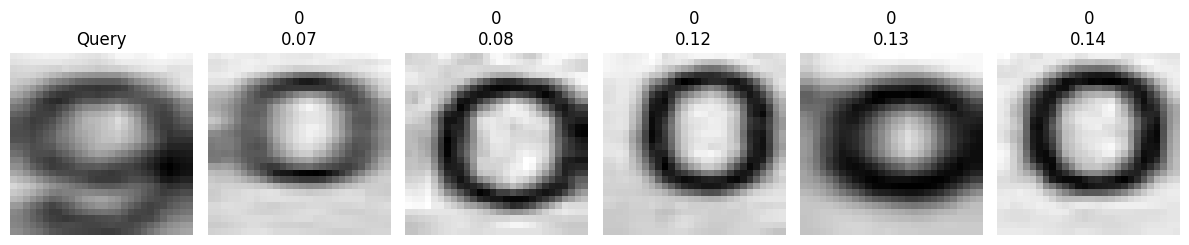

In [194]:
print(f"\n Wrong predictions: {len(wrong_cases)}")

for test_img, x1, template_labels, distances, true_label, pred_label, filename in wrong_cases:
    print(f"Filename: {filename} True: {true_label} | Predicted: {pred_label}")
    plot_top_k_matches(test_img, x1, template_labels, distances, top_k=5)


In [195]:

true_labels = []
predicted_labels = []
wrong_cases = []
from collections import Counter
top_k = 5  # Number of nearest neighbors to consider

for i, test_img in enumerate(x_test_1):
    # 1) Filename and ground truth
    filename = os.path.basename(val_image_paths[i])
    true_label_str = str(y_test_1[i])

    # 2) Generate pairs and compute distances
    x0, x1, template_labels, _ = generate_test_template_pairs([test_img], template_dict)
    distances = model.predict([x0, x1]).flatten()

    # 3) Find top-K closest templates
    top_inds = np.argsort(distances)[:top_k]
    top_labels = [template_labels[idx] for idx in top_inds]

    # 4) Majority vote among top-K labels
    predicted_label = Counter(top_labels).most_common(1)[0][0]

    # 5) Record results
    true_labels.append(true_label_str)
    predicted_labels.append(predicted_label)

    if predicted_label != true_label_str:
        wrong_cases.append((test_img, x1, template_labels, distances, true_label_str, predicted_label, filename))

        print(f"Filename: {filename} | True: {true_label_str} | Predicted: {predicted_label}")

# 6) Compute overall accuracy
essential_accuracy = np.mean(np.array(true_labels) == np.array(predicted_labels))
print(f"Accuracy: {essential_accuracy*100:.2f}%")


5/5 [==============================] - 0s 14ms/step
Filename: img1346_02.jpg | True: 0 | Predicted: 2
5/5 [==============================] - 0s 16ms/step
Filename: img1402_02.jpg | True: 0 | Predicted: 2
5/5 [==============================] - 0s 14ms/step
Filename: img1307_07.jpg | True: 3 | Predicted: 5
5/5 [==============================] - 0s 15ms/step
Filename: img1368_07.jpg | True: 3 | Predicted: 5
5/5 [==============================] - 0s 14ms/step
Filename: img1314_01.jpg | True: 5 | Predicted: 8
5/5 [==============================] - 0s 15ms/step
Filename: img1432_06.jpg | True: 5 | Predicted: 8
5/5 [==============================] - 0s 14ms/step
Filename: img1432_07.jpg | True: 5 | Predicted: 8
5/5 [==============================] - 0s 14ms/step
Filename: img1448_06.jpg | True: 6 | Predicted: 8
5/5 [==============================] - 0s 28ms/step
Filename: img1526_07.jpg | True: 6 | Predicted: 8
5/5 [==============================] - 0s 14ms/step
Filename: img1346_06.jpg | Tru


 Wrong predictions: 16
Filename: img1346_02.jpg True: 0 | Predicted: 2


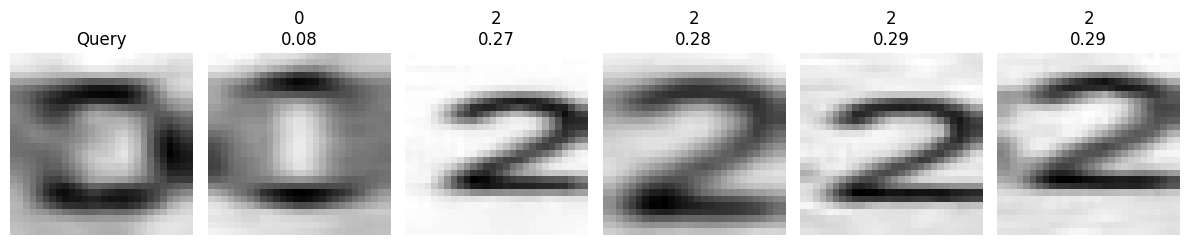

Filename: img1402_02.jpg True: 0 | Predicted: 2


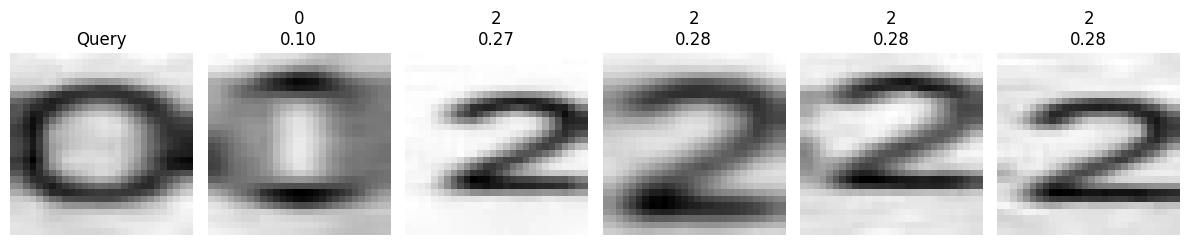

Filename: img1307_07.jpg True: 3 | Predicted: 5


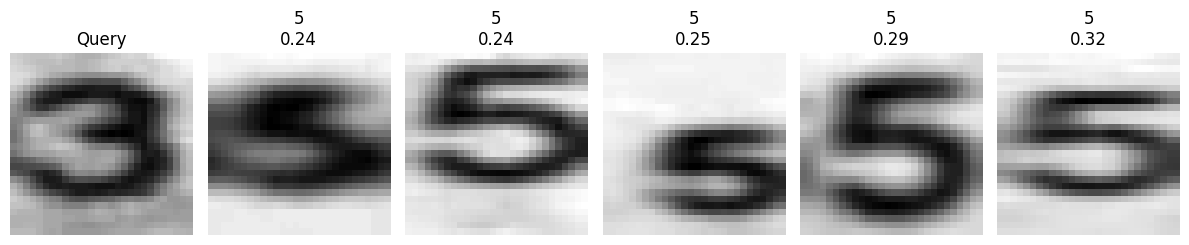

Filename: img1368_07.jpg True: 3 | Predicted: 5


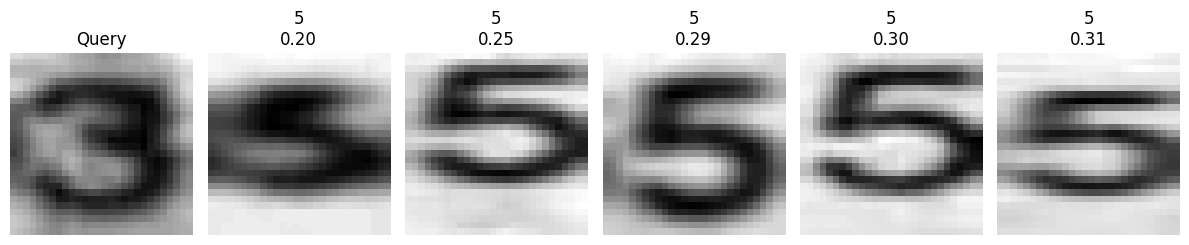

Filename: img1314_01.jpg True: 5 | Predicted: 8


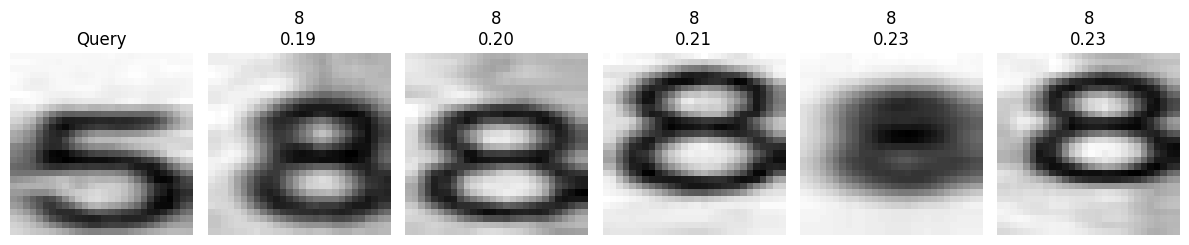

Filename: img1432_06.jpg True: 5 | Predicted: 8


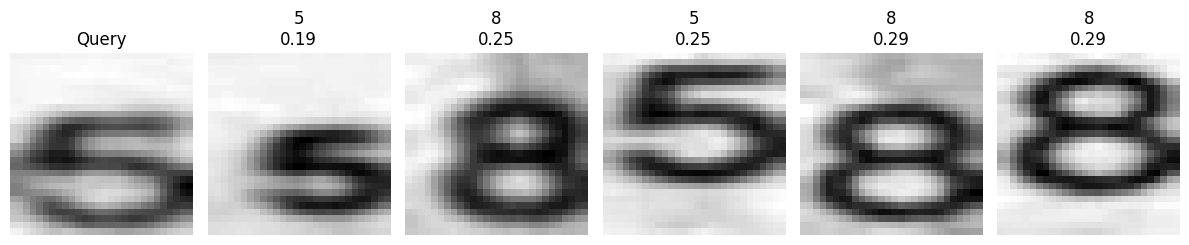

Filename: img1432_07.jpg True: 5 | Predicted: 8


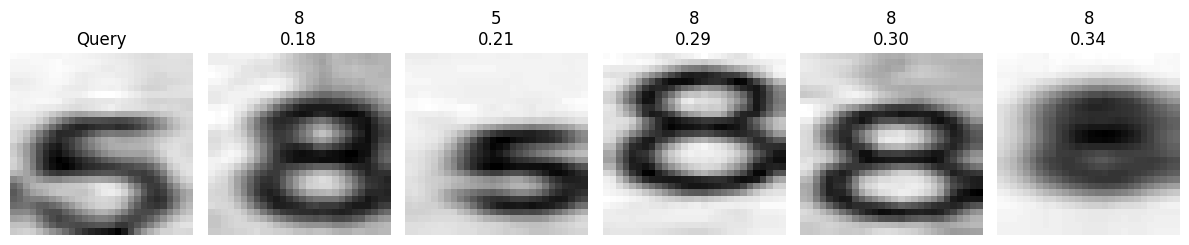

Filename: img1448_06.jpg True: 6 | Predicted: 8


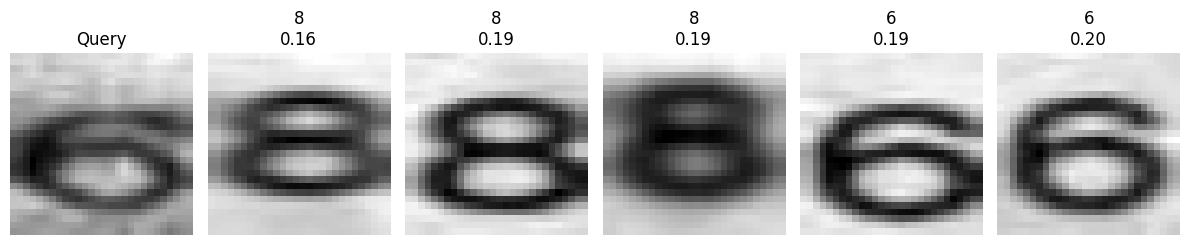

Filename: img1526_07.jpg True: 6 | Predicted: 8


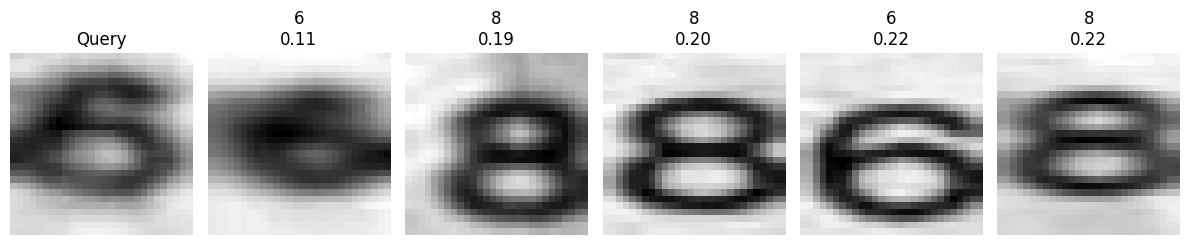

Filename: img1346_06.jpg True: 7 | Predicted: 2


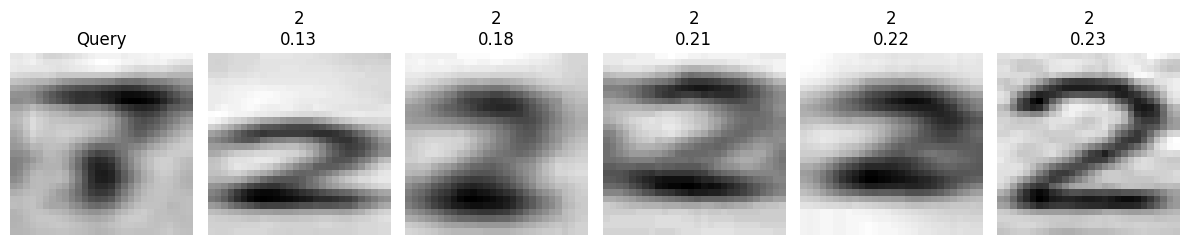

Filename: img1298_06.jpg True: 8 | Predicted: 6


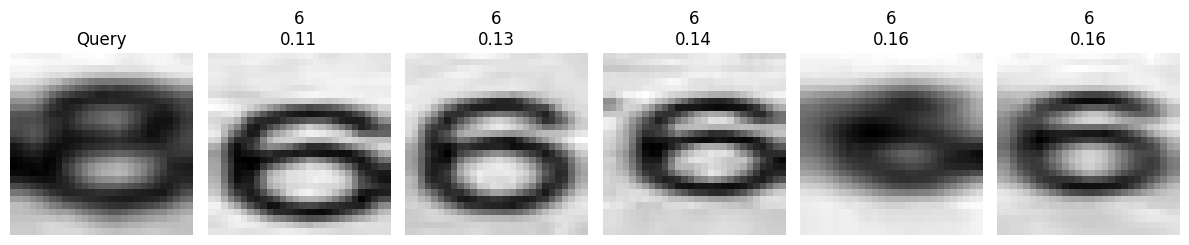

Filename: img1451_06.jpg True: 8 | Predicted: 6


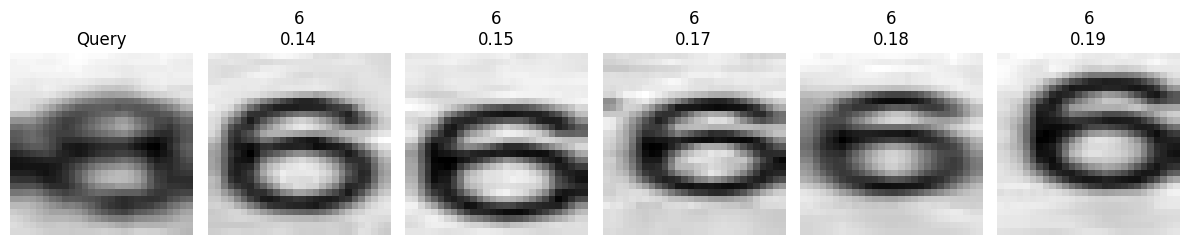

Filename: img1319_05.jpg True: 9 | Predicted: 0


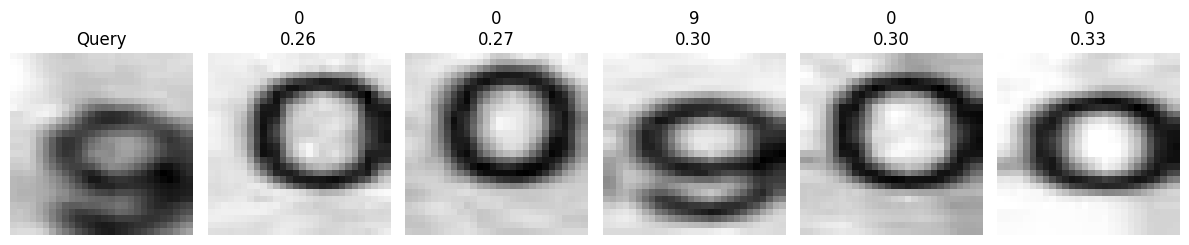

Filename: img1319_07.jpg True: 9 | Predicted: 0


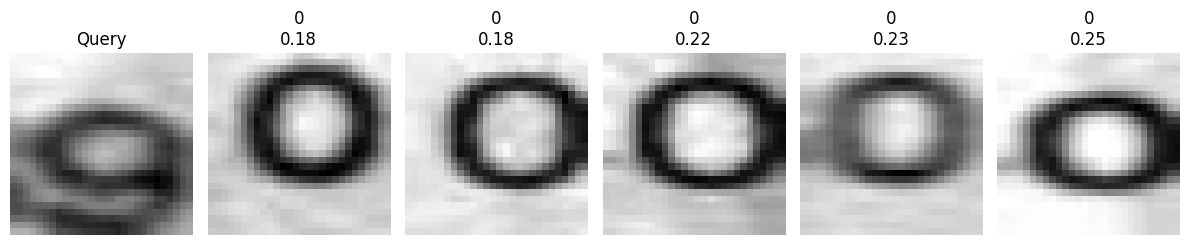

Filename: img1430_07.jpg True: 9 | Predicted: 0


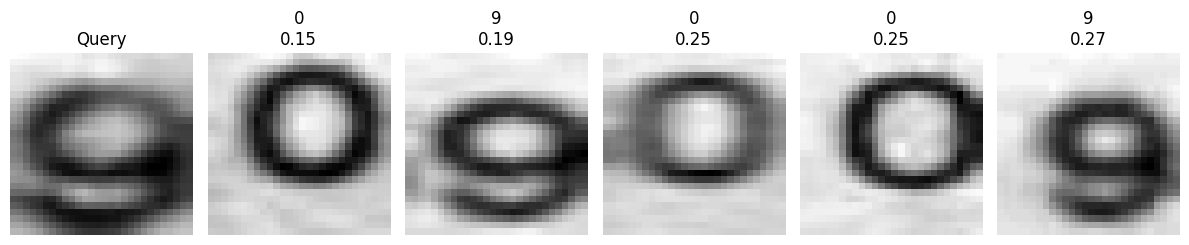

Filename: img1617_01.jpg True: 9 | Predicted: 0


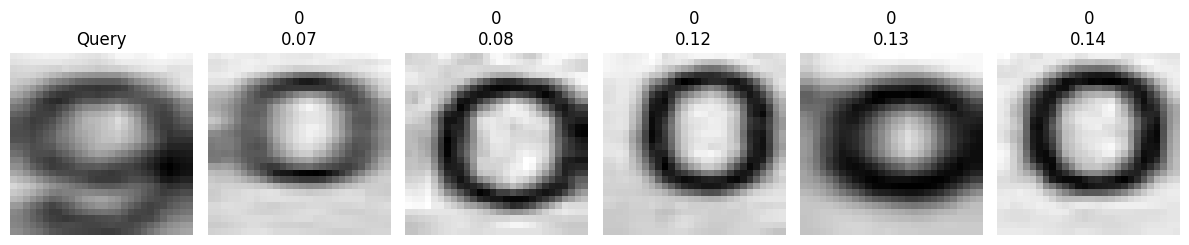

In [196]:
print(f"\n Wrong predictions: {len(wrong_cases)}")

for test_img, x1, template_labels, distances, true_label, pred_label, filename in wrong_cases:
    print(f"Filename: {filename} True: {true_label} | Predicted: {pred_label}")
    plot_top_k_matches(test_img, x1, template_labels, distances, top_k=5)


In [197]:
from collections import defaultdict
import os

# Step 1: Group predictions by base filename
grouped_preds = defaultdict(list)

for path, pred_char in zip(val_image_paths, predicted_labels):
    fname = os.path.basename(path)                  # e.g., dob_00001_03.jpg
    key = '_'.join(fname.split('_')[:1])+'.jpg'   # → dob_00001.jpg
    grouped_preds[key].append((path, pred_char))

# Step 2: Assemble final predictions by sorting crop indices
final_rows = []

for key in sorted(grouped_preds.keys()):
    crops = grouped_preds[key]

    # Sort by crop index (_00, _01, ...)
    sorted_crops = sorted(crops, key=lambda x: int(os.path.splitext(x[0])[0].split('_')[-1]))
    predicted_str = ''.join(char for _, char in sorted_crops)

    # Save (filename, predicted_string)
    final_rows.append((key, predicted_str))

import pandas as pd

df = pd.DataFrame(final_rows, columns=["filename", "label"])
df.to_csv("dob_predictions.csv", index=False)
print("✅ Saved to dob_predictions.csv")


✅ Saved to dob_predictions.csv


In [198]:
# Load predicted results
df_pred = pd.read_csv("dob_predictions.csv", dtype =str)
df_gt = pd.read_csv("gt_2s.csv",dtype=str)

# Merge with ground truth
df_merged = pd.merge(df_pred, df_gt, on="filename", how="inner")

# Format prediction as DD/MM/YYYY (add slashes)
df_merged["formatted_predicted_label"] = df_merged["label"].apply(
    lambda s: f"{s[:2]}/{s[2:4]}/{s[4:]}" if len(str(s)) == 8 else str(s)
)

# Now compare directly to ground truth label
correct = df_merged["formatted_predicted_label"] == df_merged["dob"]
accuracy = correct.mean()

print(f"✅ Accuracy: {accuracy * 100:.2f}% ({correct.sum()}/{len(df_merged)})")


✅ Accuracy: 92.97% (172/185)
